##### Introdução

O presente trecho tem como objetivo estabelecer uma linha de base (baseline) comparativa por meio da aplicação de métodos estatísticos, visando fornecer um ponto de referência para futuras comparações. Essa baseline servirá como fundamento para avaliar e comparar de forma objetiva os resultados obtidos com diferentes configurações ao longo do desenvolvimento do projeto, particularmente no contexto da Neuro-Evolução.

**dados**
-   Os dados analisados são referentes às <a href="https://gml.noaa.gov/ccgg/trends/gl_data.html">Tendências do dióxido de carbono atmosférico</a>, cobrindo o período de 1979 à 2024.
-   As medições estão na escala de partes por milhão (ppm). Por exemplo uma concentração de 0,000400 corresponde a 400 ppm.
    -   **Mais especificamente:** a medição representa uma fração molar de CO₂ no ar seco, ou seja, o número de moléculas de dióxido de carbono dividido pelo número total de moléculas no ar (incluindo o próprio CO₂), após a remoção do vapor d’água.

**dataSet**
-   Obtido a partir do site <a href="https://gml.noaa.gov/">gml.noaa.gov</a>, que é um site oficial do governo dos Estados Unidos, cuja sigla GML e NOAA significam respectivamente, Global Monitoring Laboratory (Laboratório de Monitoramento Global) e National Oceanic and Atmospheric Administration (Administração Oceânica e Atmosférica Nacional)

# Análise de Séries Temporais com métodos estatísticos

## Índice
- [Leitura e tratamento](#leitura-e-tratamento)
- [Análise Exploratória](#analise-exploratoria)
- [Transformações](#transformacoes)
- [Predição](#predicao)
- [Comparações](#comparacoes)
- [Auto Arima](#auto-arima)

## Pip Install e importação de bibliotecas

In [80]:
# pip install pandas numpy statsmodels scikit-learn importlib

In [81]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import aux_functions as aux
import importlib
importlib.reload(aux)

<module 'aux_functions' from '/home/elizeta/VsCode/Otimizacao-de-Gas-com-Neuro-Evolucao/Trends_Atmospheric_CO2/aux_functions.py'>

## Leitura e Tratamento<a id="leitura-e-tratamento"></a>

In [82]:
full_data_set = aux.ler_csv('dataSet.csv')
data_set = aux.ler_csv('dataSet.csv', average_only=True)

##### DataSet completo

In [83]:
full_data_set

,data,average,average_unc,trend,trend_unc
0,1979-01-01,336.56,0.11,335.92,0.10
1,1979-02-01,337.29,0.09,336.26,0.10
2,1979-03-01,337.88,0.11,336.51,0.10
3,1979-04-01,338.32,0.13,336.72,0.11
4,1979-05-01,338.26,0.04,336.71,0.11
...,...,...,...,...,...
547,2024-08-01,420.19,0.10,423.08,0.06
548,2024-09-01,420.50,0.10,423.35,0.06
549,2024-10-01,422.32,0.10,423.81,0.06
550,2024-11-01,424.07,0.10,424.16,0.06


In [84]:
full_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         552 non-null    datetime64[ns]
 1   average      552 non-null    float64       
 2   average_unc  552 non-null    float64       
 3   trend        552 non-null    float64       
 4   trend_unc    552 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 21.7 KB


##### DataSet básico

In [85]:
data_set

data
1979-01-01    336.56
1979-02-01    337.29
1979-03-01    337.88
1979-04-01    338.32
1979-05-01    338.26
               ...  
2024-08-01    420.19
2024-09-01    420.50
2024-10-01    422.32
2024-11-01    424.07
2024-12-01    425.19
Name: average, Length: 552, dtype: float64

In [86]:
data_set.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 552 entries, 1979-01-01 to 2024-12-01
Series name: average
Non-Null Count  Dtype  
--------------  -----  
552 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


## Análise Exploratória <a id="analise-exploratoria"></a>

### Análise dos dados

##### Histogram & Line

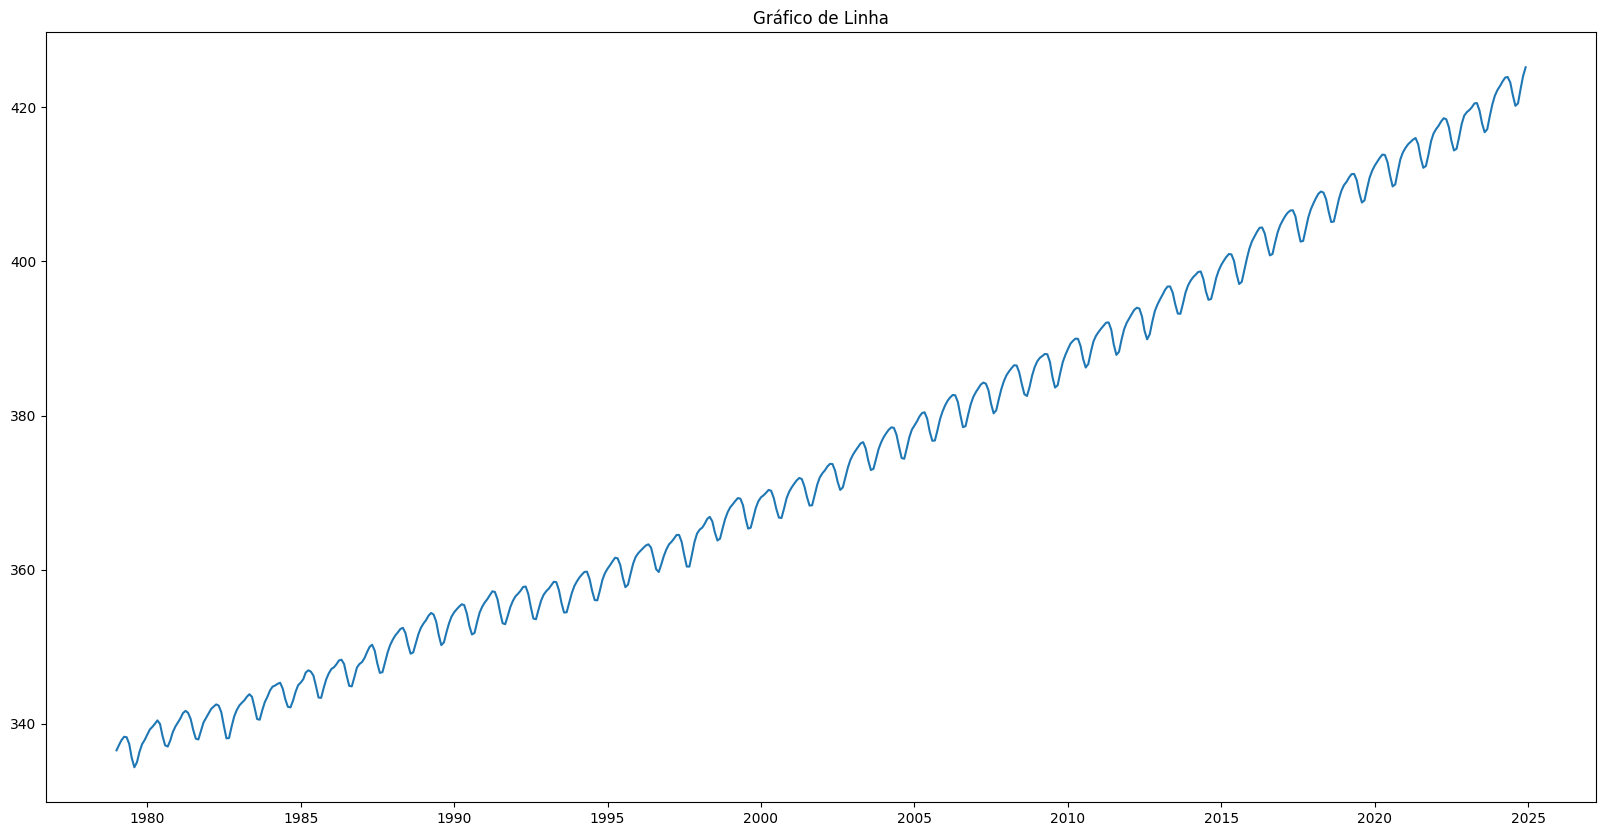

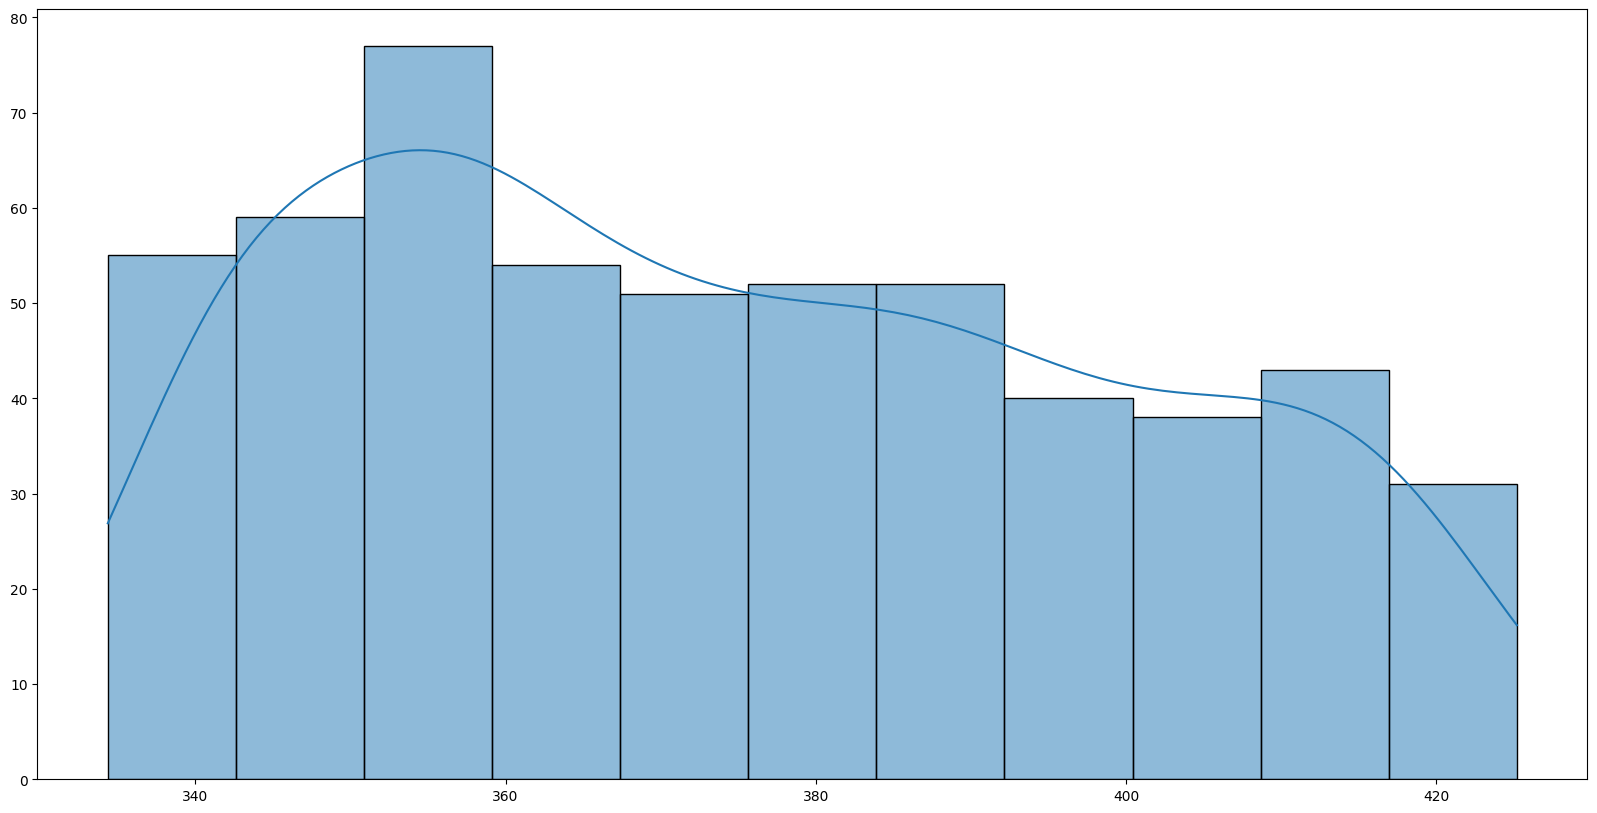

In [87]:
aux.plotLine(data_set)
aux.plotHistogram(data_set)

##### Decomposition

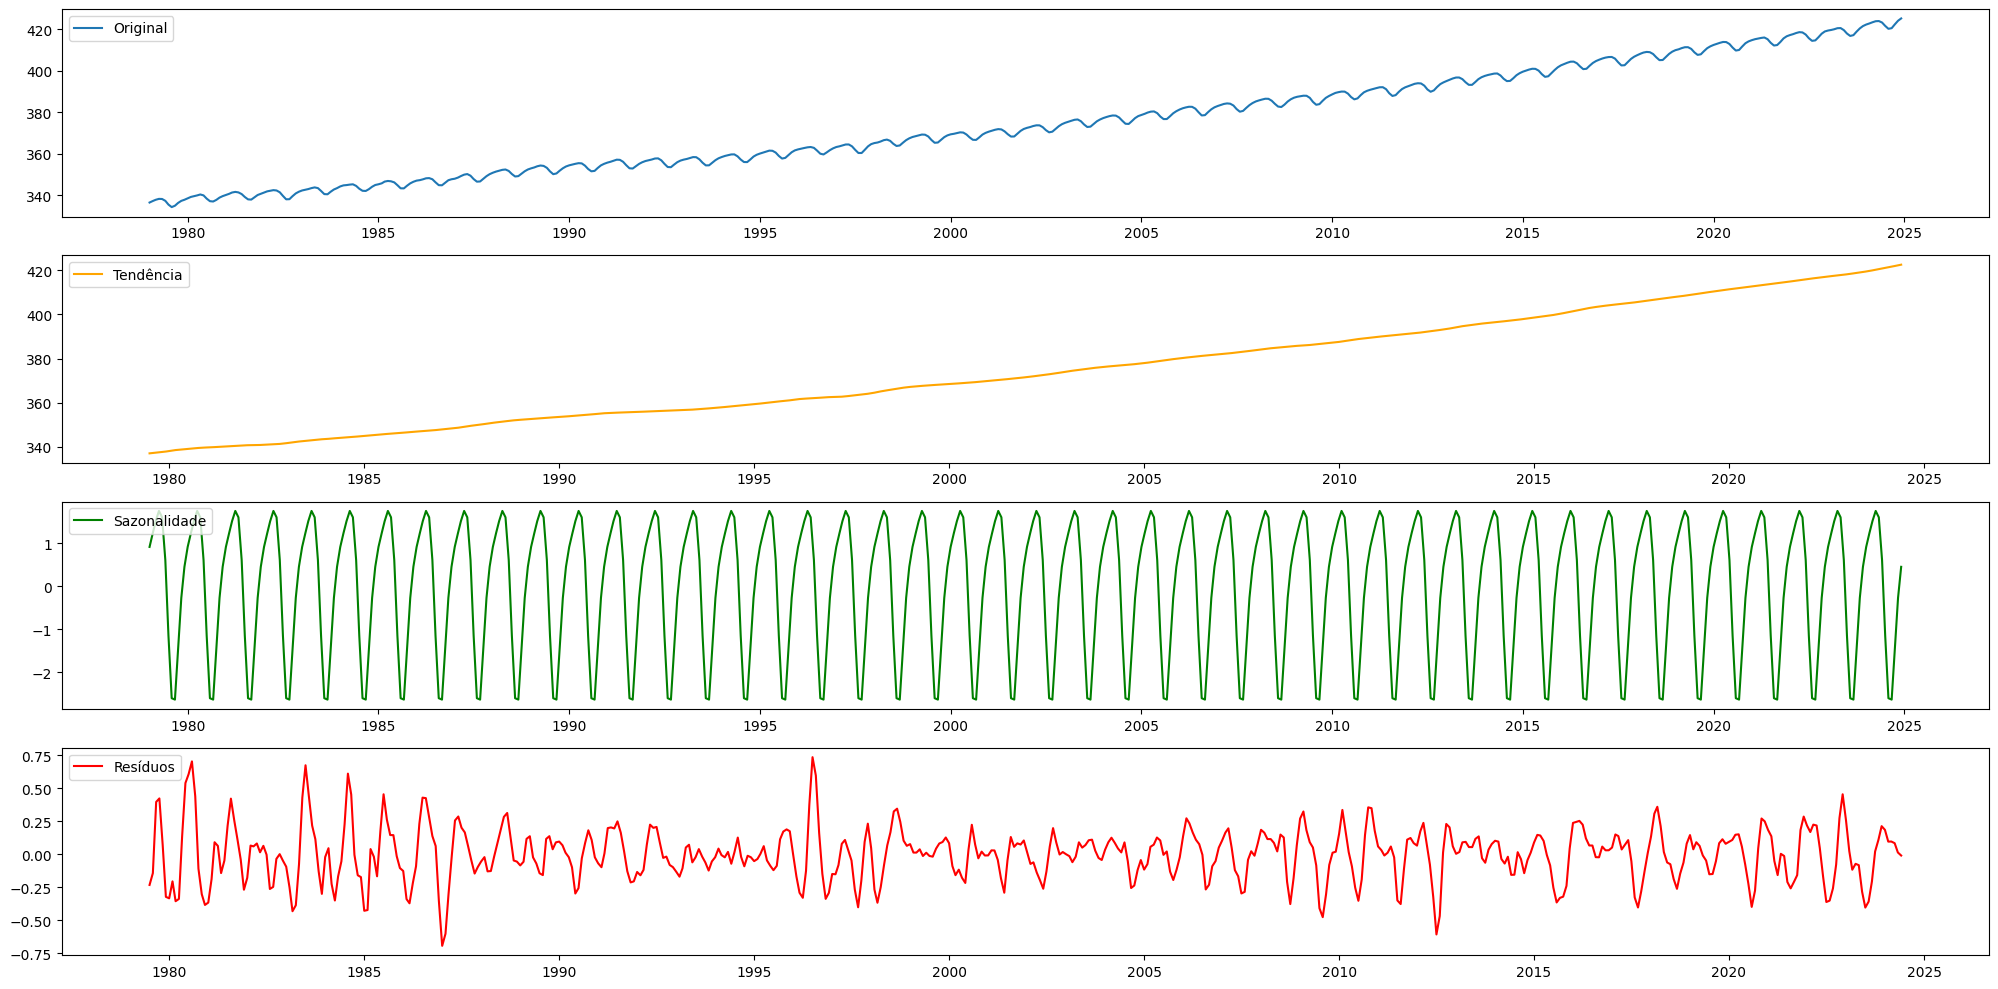

In [88]:
aux.plotDecomposicao(data_set)

Com estes gráficos percebo:
-   Não há outliers
-   Tendência bem definida linear
-   comportamento ciclico

##### PACF & ACF

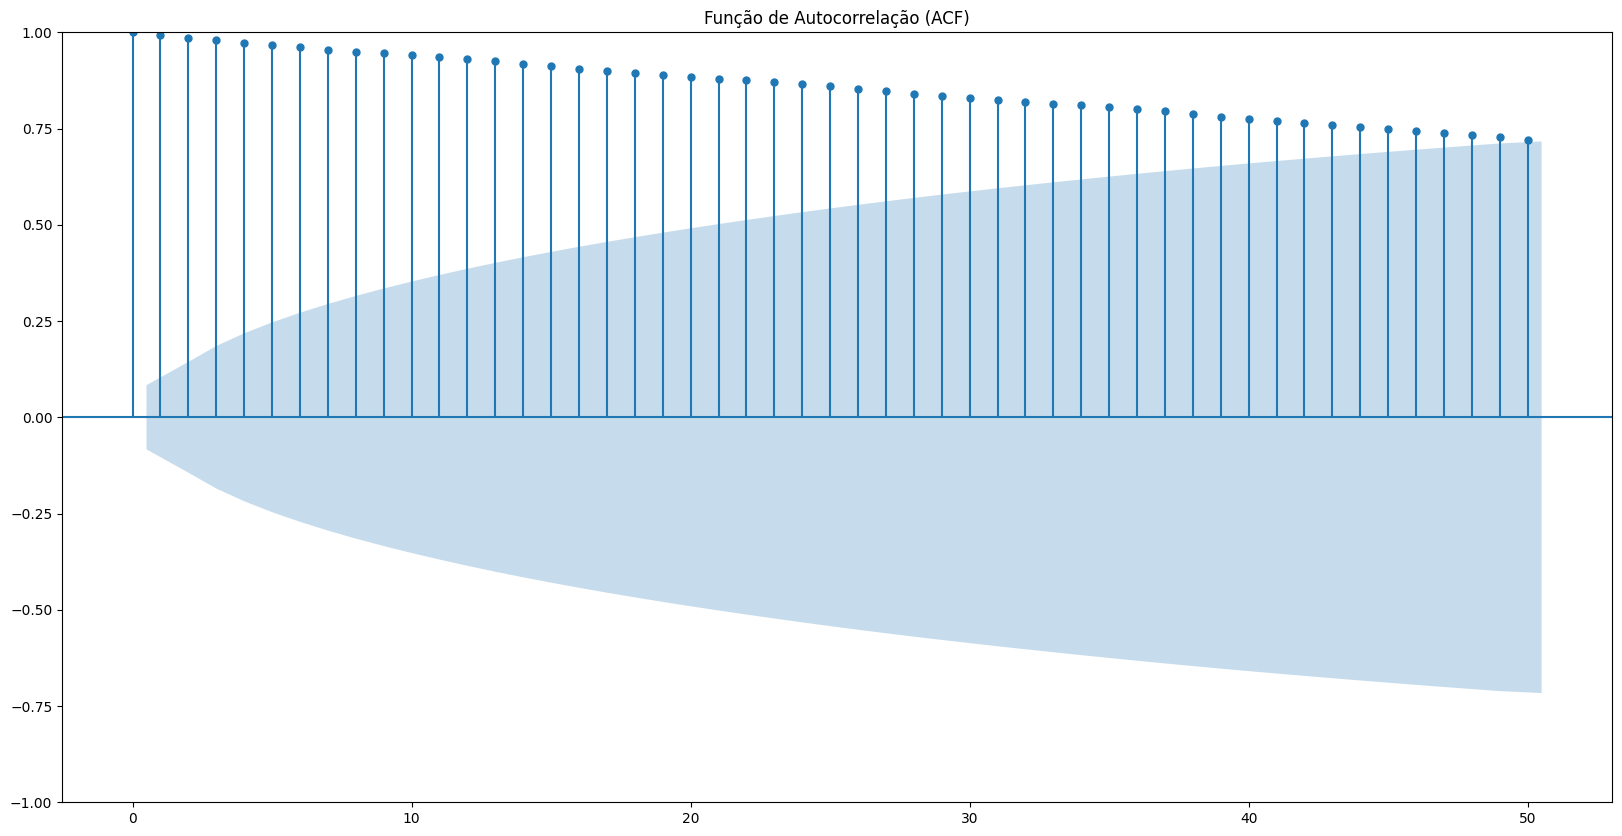

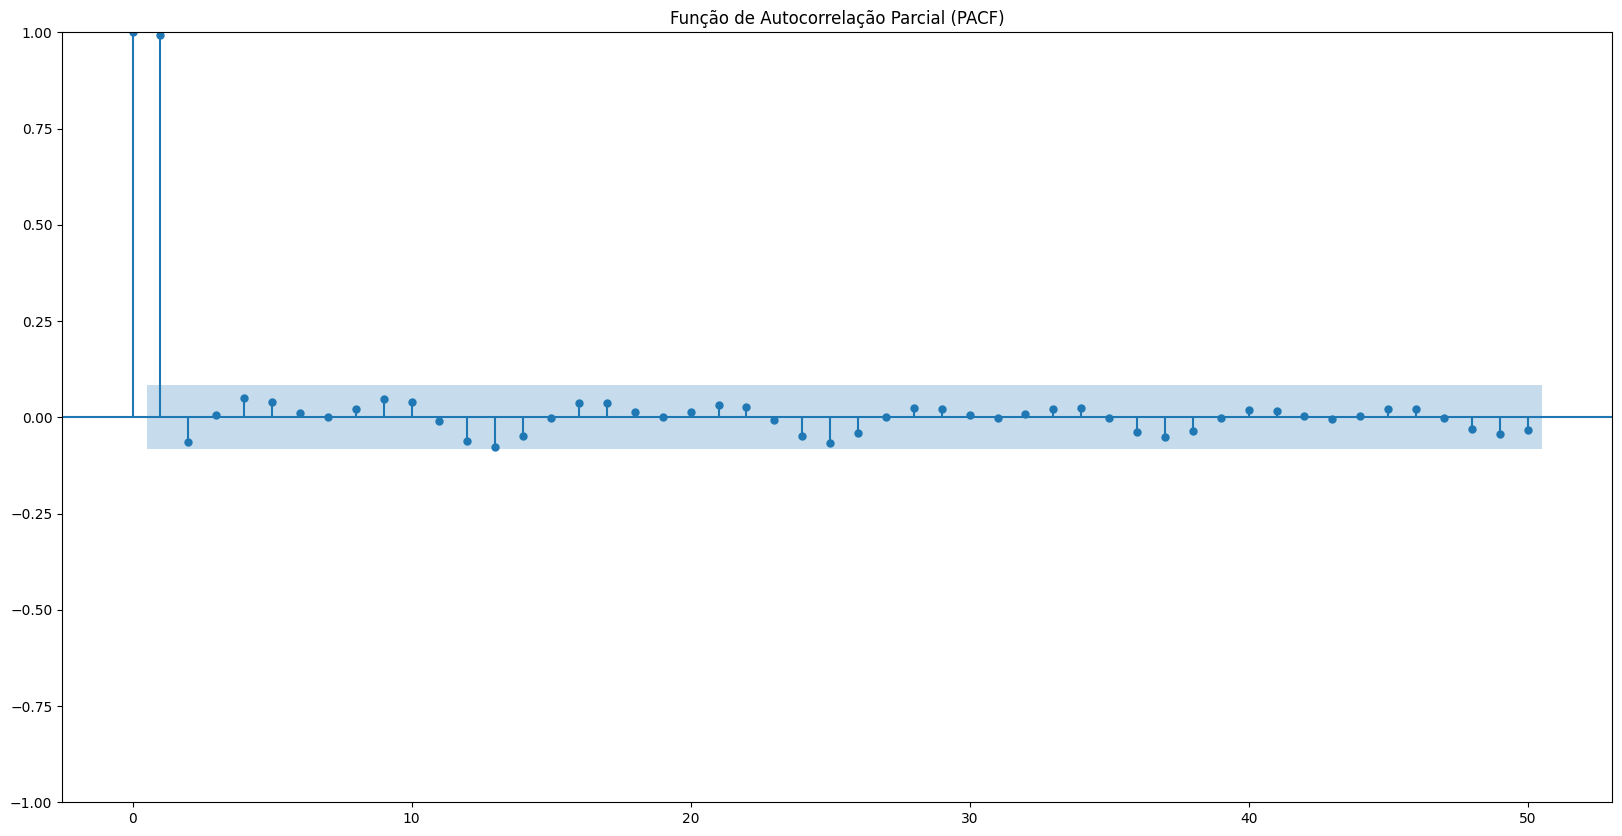

In [89]:
aux.plotAutoCorrelation(data_set)
aux.plotPartialAutoCorrelation(data_set)

#### Análise estatística

In [90]:
aux.adfullerTest(data_set)
aux.andersonTest(data_set)
aux.kolmogorovTest(data_set)

Estatística do teste ADF: 4.648385021622551
Valor-p: 1.0000000000000000
Valores críticos:
   1%: -3.442701754304053
   5%: -2.866988120523906
   10%: -2.5696716542766693
A série não é estacionária.

Teste de Anderson-Darling
Estatística: 7.42896891
Valores Críticos: ['0.57200000', '0.65100000', '0.78100000', '0.91100000', '1.08400000']
Níveis de Significância: [15.  10.   5.   2.5  1. ]
Para um nível de significância de 15.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 10.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 5.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 2.5%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 1.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)

Teste de Kolmogorov-Smirnov
Estatística: 1.00000000
Valor

In [91]:
aux.detectar_outliers_iqr(data_set, true_only=True)

Series([], Name: average, dtype: float64)

In [92]:
aux.detectar_outliers_zscore(data_set, true_only=True)

Series([], Name: average, dtype: float64)

## Transformações <a id="transformacoes"></a>

**Separação dos dados**

In [93]:
# Calcula o índice de corte
test_cut = int(len(data_set) * 0.75)
validation_cut = int(len(data_set) * 1)

# Divide a série em treino e teste  
train = data_set.iloc[:test_cut]
test = data_set.iloc[test_cut:validation_cut]
validation = data_set.iloc[validation_cut:]

### Diferenciação

395.96


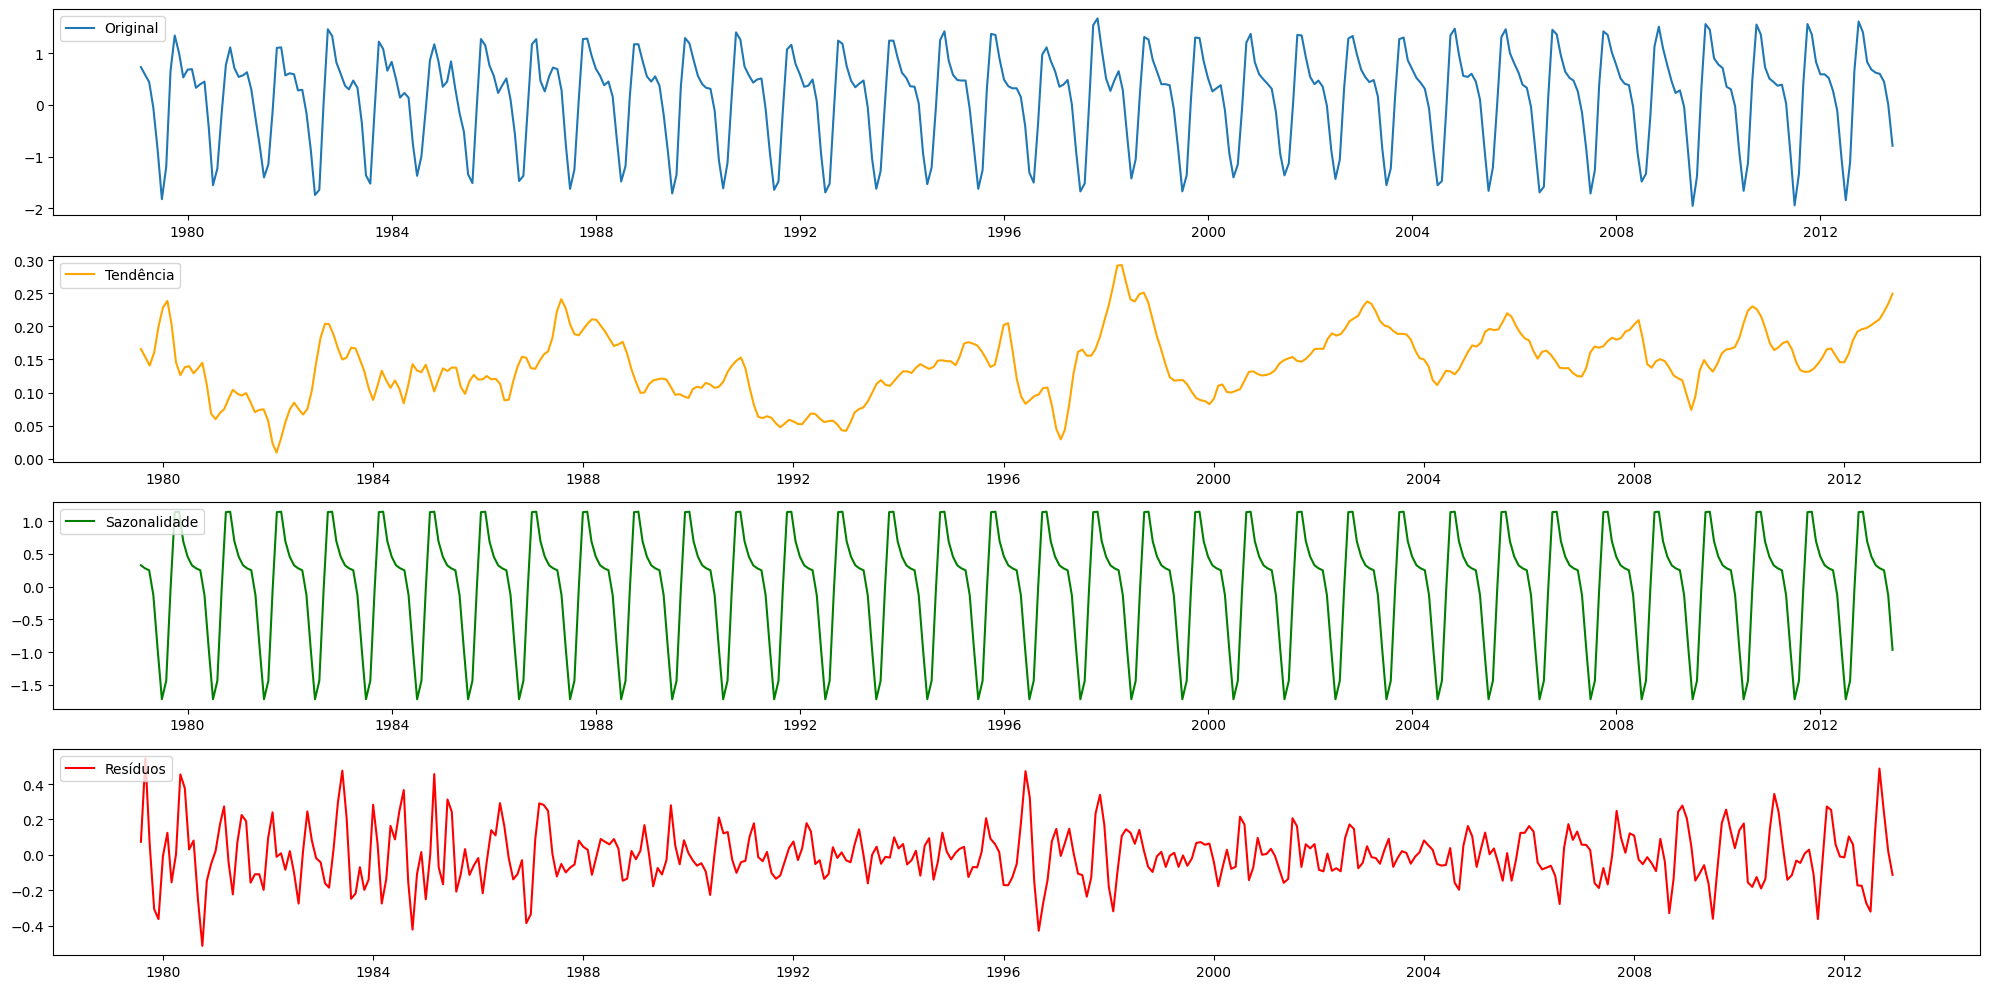

In [94]:
first_value = train.iloc[-1]
diff_data = train.diff().dropna()

print (first_value)
aux.plotDecomposicao(diff_data)

### Pós Diferenciação

Estatística do teste ADF: -4.2275045896734875
Valor-p: 0.0005917151742191
Valores críticos:
   1%: -3.4470566389664703
   5%: -2.8689037160476016
   10%: -2.570692663557422
A série não é estacionária.

Teste de Anderson-Darling
Estatística: 12.16690357
Valores Críticos: ['0.57100000', '0.65000000', '0.78000000', '0.90900000', '1.08200000']
Níveis de Significância: [15.  10.   5.   2.5  1. ]
Para um nível de significância de 15.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 10.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 5.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 2.5%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)
Para um nível de significância de 1.0%, rejeita a hipótese nula (os dados não seguem uma distribuição normal)

Teste de Kolmogorov-Smirnov
Estatística: 0.20789499
V

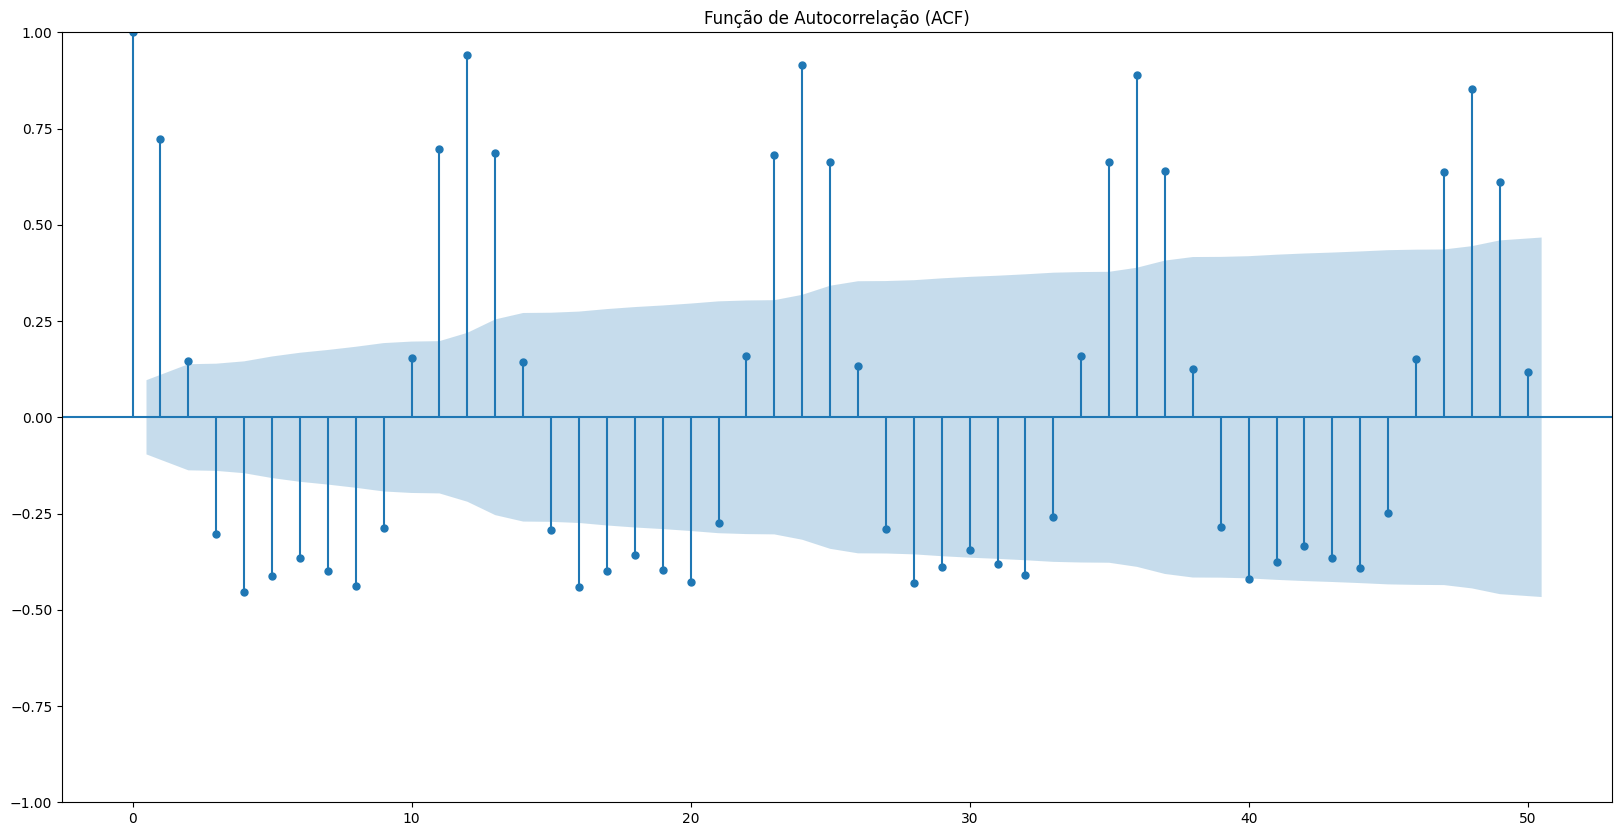

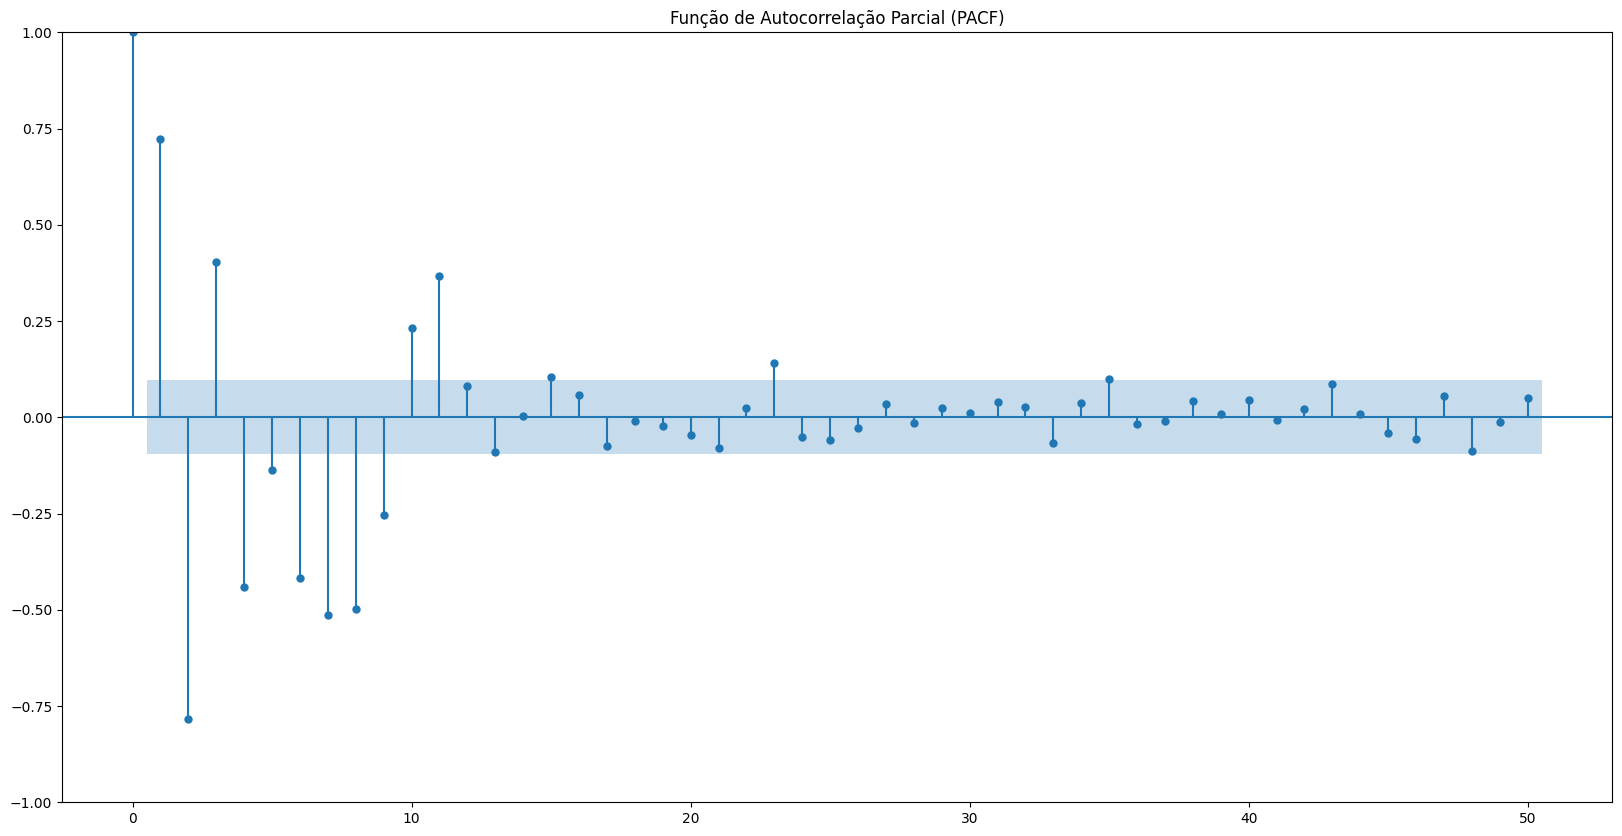

In [95]:
aux.adfullerTest(diff_data)
aux.andersonTest(diff_data)
aux.kolmogorovTest(diff_data)
aux.plotAutoCorrelation(diff_data)
aux.plotPartialAutoCorrelation(diff_data)

#### Testando uma segunda diferenciação

In [96]:
# first_value2 = diff_data.iloc[0]
# diff_data = diff_data.diff().dropna()

# plotDecomposicao(diff_data)

# adfullerTest(diff_data)
# andersonTest(diff_data)
# kolmogorovTest(diff_data)
# plotAutoCorrelation(diff_data)
# plotPartialAutoCorrelation(diff_data)

## Predição <a id="predicao"></a>

### SARIMAX

/home/elizeta/VsCode/Otimizacao-de-Gas-com-Neuro-Evolucao/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/elizeta/VsCode/Otimizacao-de-Gas-com-Neuro-Evolucao/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/elizeta/VsCode/Otimizacao-de-Gas-com-Neuro-Evolucao/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


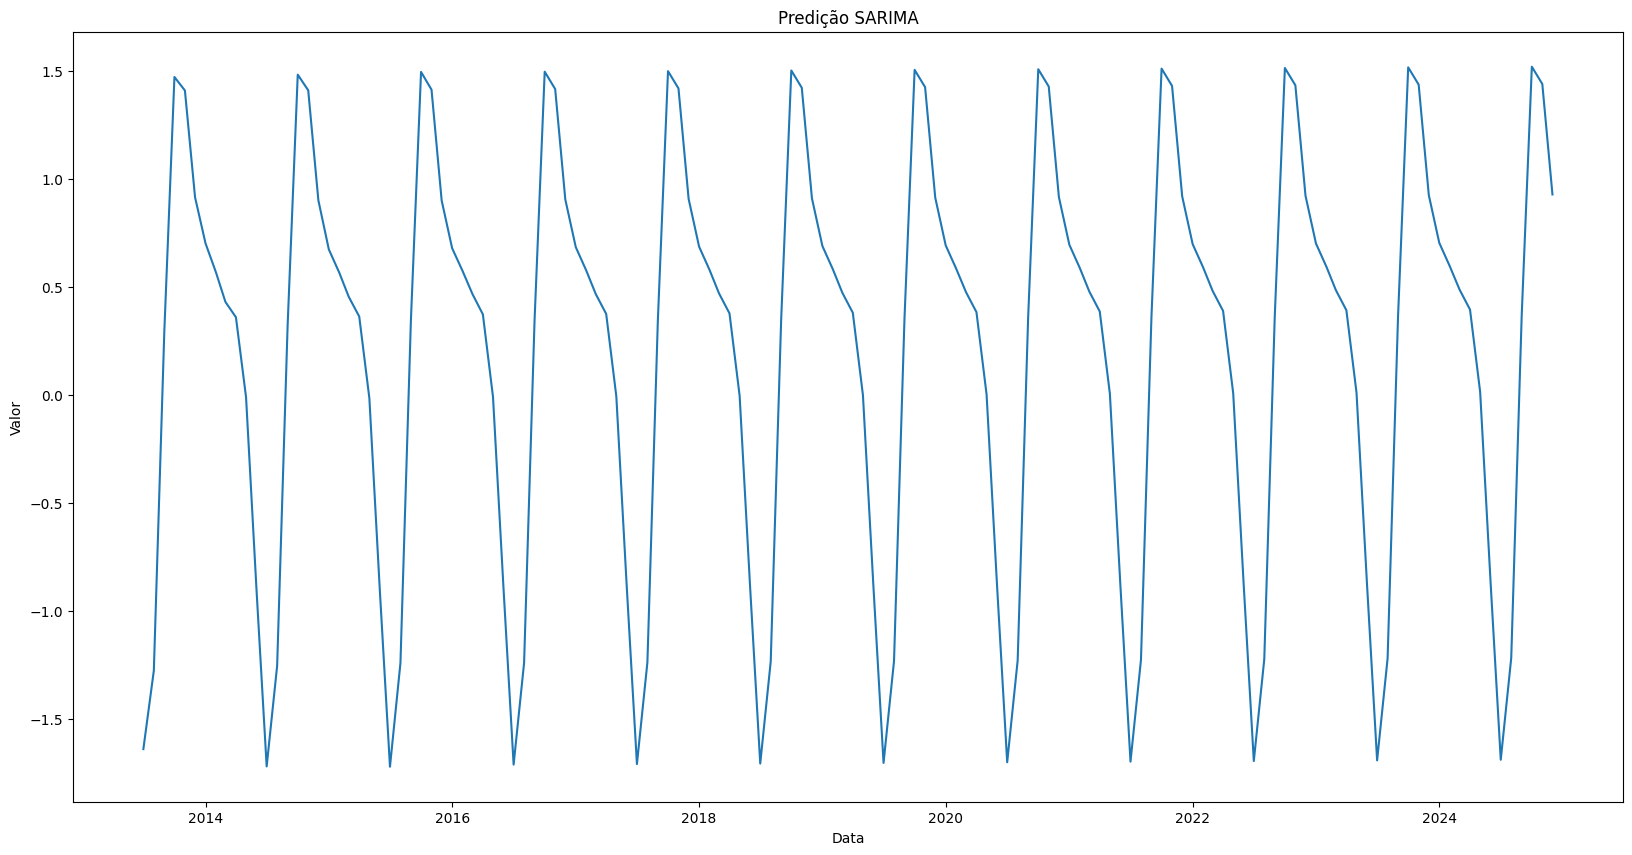

In [97]:
predicaoSarima = SARIMAX(diff_data, order=(3, 1, 9), seasonal_order=(2, 1, 1, 12)).fit()
predicao = predicaoSarima.forecast(steps=len(test))

aux.plotLine(predicao, title='Predição SARIMA', xlabel='Data', ylabel='Valor')

## Comparações <a id="comparacoes"></a>

### Comparação Gráfica

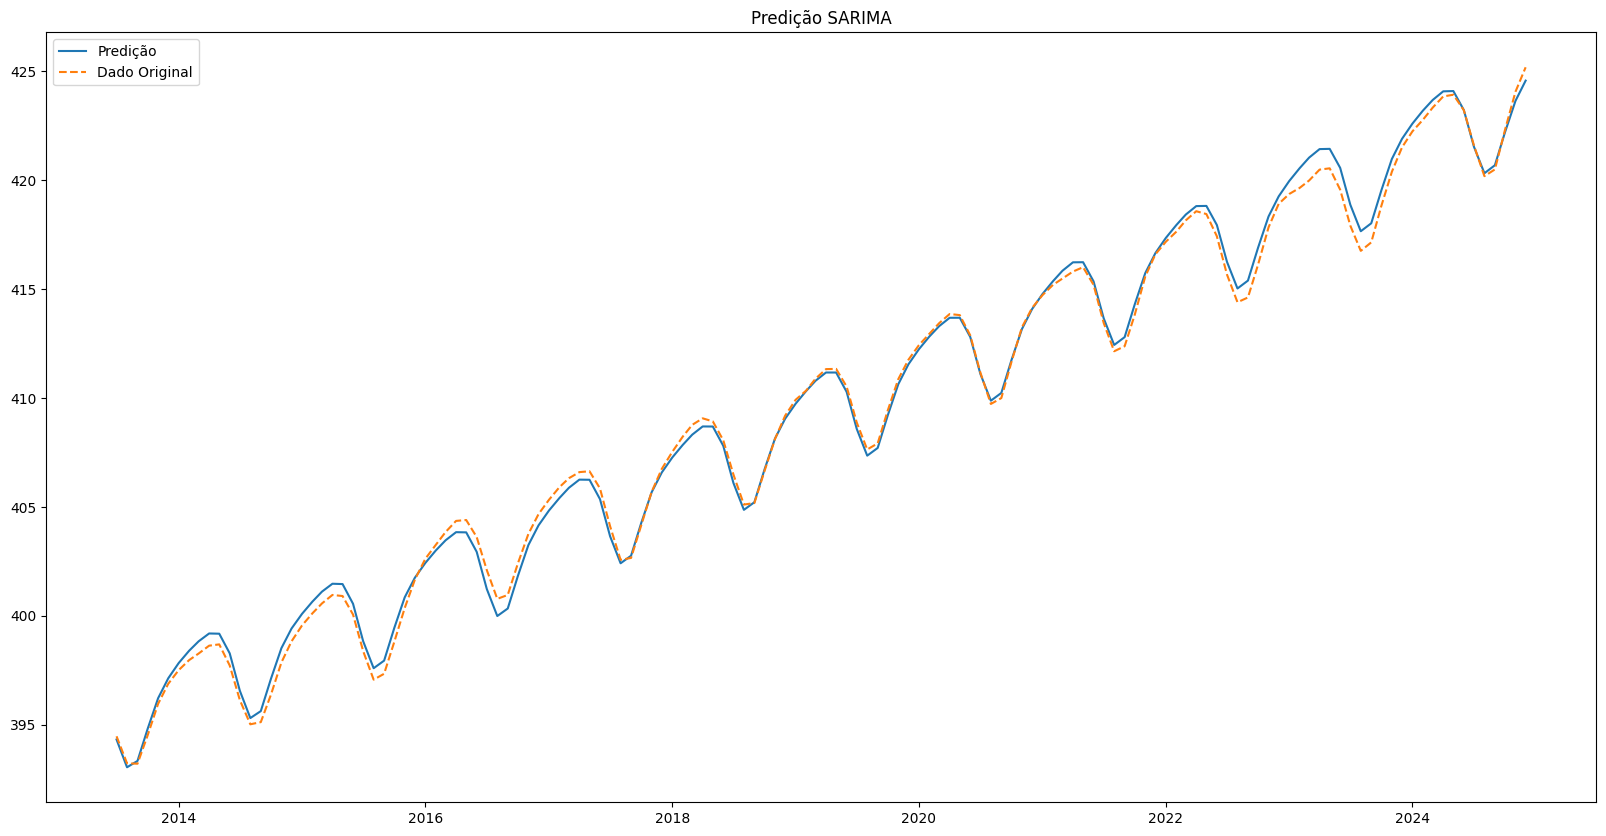

In [98]:
revert_diff = np.cumsum(predicao) + first_value

aux.plotLine(revert_diff,
             df_label="Predição",
             title='Predição SARIMA', 
             compare=test, 
             compare_label="Dado Original")

### Comparação Estatística <a id="statistic-comp"></a>

  🔹 R² (Coeficiente de Determinação): ------------ 0.9972
  🔹 RMSE (Raiz Quadrada do Erro Quadrático Médio): 0.4453
  🔹 MAE (Erro Absoluto Médio): ------------------- 0.3733
  🔹 MAPE (Erro Percentual Absoluto): ------------- 0.0913%
  🔹 Acurácia: ------------------------------------ 99.9087%


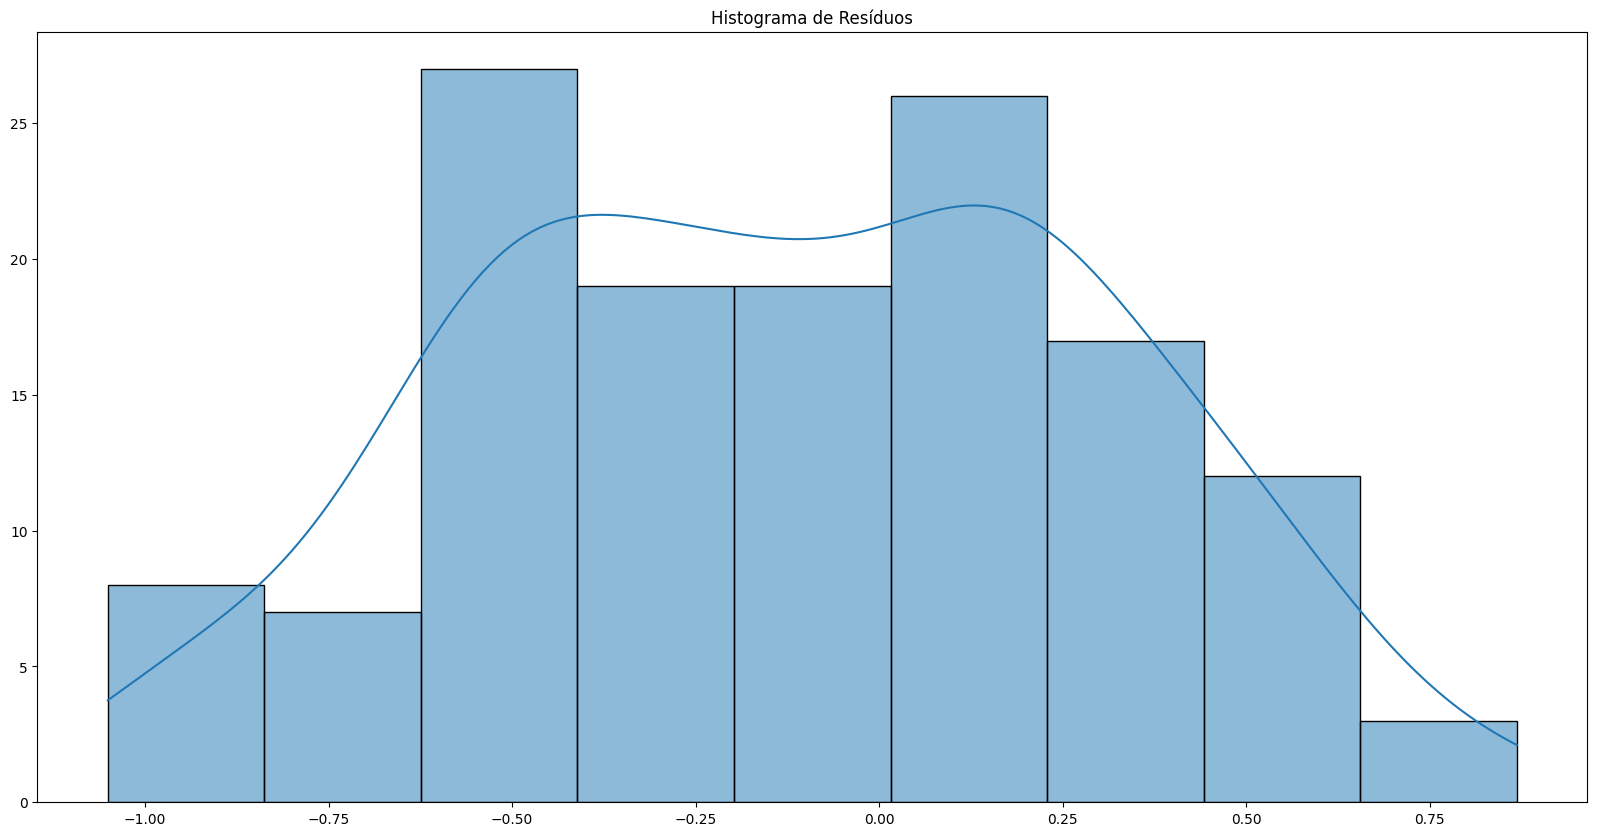

In [99]:
dataParaComparativo = test.dropna()
dataPredicaoTratada = revert_diff.dropna()

dataParaComparativo = dataParaComparativo[:dataPredicaoTratada.size]
dataPredicaoTratada = dataPredicaoTratada[:dataParaComparativo.size]

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Evitar divisão por zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calcular métricas
# f1 = f1_score(dataParaComparativo, dataPredicaoTratada)
r2 = r2_score(dataParaComparativo, dataPredicaoTratada)
rmse = np.sqrt(mean_squared_error(dataParaComparativo, dataPredicaoTratada))
mae = mean_absolute_error(dataParaComparativo, dataPredicaoTratada)
mape = mean_absolute_percentage_error(dataParaComparativo.values, dataPredicaoTratada.values)
accuracy = 100 - mape

# print(f"  🔹 R² (Coeficiente de Determinação): {f1:.2f}") #Função criada para teste, entretanto não foi possivel aplicar aqui
print(f"  🔹 R² (Coeficiente de Determinação): ------------ {r2:.4f}")
print(f"  🔹 RMSE (Raiz Quadrada do Erro Quadrático Médio): {rmse:.4f}")
print(f"  🔹 MAE (Erro Absoluto Médio): ------------------- {mae:.4f}")
print(f"  🔹 MAPE (Erro Percentual Absoluto): ------------- {mape:.4f}%")
print(f"  🔹 Acurácia: ------------------------------------ {accuracy:.4f}%")

aux.plotHistogram(np.array(dataParaComparativo) - np.array(dataPredicaoTratada), title="Histograma de Resíduos")

## Auto Arima <a id="auto-arima"></a>

In [100]:
# aux.auto_arima(diff_data)